In [1]:
# Import những thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from typing import List, Tuple, Optional

In [2]:
# Module phụ trách thực hiện việc nội suy đa thức bằng Spline bậc ba tự nhiên
class NaturalCubicSpline:
    def __init__(self, X: List[float], Y: List[float]):
        # self.points = points
        self.X = X
        self.Y = Y
        self.compute_coefficients()

    def compute_coefficients(self):
        n = len(self.X)
        h = np.diff(self.X)

        alpha = np.zeros(n)
        for i in range(1, n - 1):
            alpha[i] = (3 / h[i]) * (self.Y[i + 1] - self.Y[i]) - (3 / h[i - 1]) * (self.Y[i] - self.Y[i - 1])

        A = np.zeros((n, n))
        A[0, 0] = 1
        A[-1, -1] = 1

        for i in range(1, n - 1):
            A[i, i - 1] = h[i - 1]
            A[i, i] = 2 * (h[i - 1] + h[i])
            A[i, i + 1] = h[i]

        c = np.linalg.solve(A, alpha)
        self.c = c[:-1] 

        self.a = self.Y[:-1]
        self.b = np.zeros(n - 1)
        self.d = np.zeros(n - 1)

        for i in range(n - 1):
            self.b[i] = (self.Y[i + 1] - self.Y[i]) / h[i] - (h[i] / 3) * (2 * c[i] + c[i + 1])
            self.d[i] = (c[i + 1] - c[i]) / (3 * h[i])

    def interpolate(self, x: float) -> Optional[float]:
        n = len(self.X)
        for i in range(n - 1):
            if self.X[i] <= x <= self.X[i + 1]:
                dx = x - self.X[i]
                return self.a[i] + self.b[i] * dx + self.c[i] * dx ** 2 + self.d[i] * dx ** 3
        return None

In [3]:
# Module này phụ trách cho công việc hồi quy đa thức
class PolynominalRegression:
    def __init__(self, X: List[float], Y: List[float], degree: int):
        self.x_min = min(X)
        self.x_max = max(X)
        self.X = self.min_max_normalize(X)
        self.Y = Y
        self.degree = degree
        self.coefs = self.compute_coefficients()

    def min_max_normalize(self, X: List[float]) -> List[float]:
        return [(x - self.x_min) / (self.x_max - self.x_min) for x in X]
    
    def normalize_single(self, x: float) -> float:
        return (x - self.x_min) / (self.x_max - self.x_min)

    def compute_coefficients(self) -> List[float]:
        n = len(self.X)
        A = np.zeros((n, self.degree + 1))
        for i in range(n):
            for j in range(self.degree + 1):
                A[i][j] = self.X[i] ** j
            
        A_T = A.T
        ATA = A_T @ A
        ATY = A_T @ np.array(self.Y).reshape(-1, 1)
        coefs = np.linalg.solve(ATA, ATY)

        return coefs.flatten().tolist()
        
    def predict(self, x: float) -> float:
        x_norm = self.normalize_single(x)
        return sum(self.coefs[i] * x_norm ** i for i in range(len(self.coefs)))

In [40]:
# Helper cho bài 1
def plot_interpolation_results(
    x_original: List[float],
    y_original: List[float],
    x_spline: Optional[List[float]] = None,
    y_spline: Optional[List[float]] = None,
    x_regression: Optional[List[float]] = None,
    y_regression: Optional[List[float]] = None,
    xlabel: str = "",
    ylabel: str = "",
    title: str = "",
    figsize: tuple = (12, 6),
):
    plt.figure(figsize=figsize)
    plt.plot(x_original, y_original, 'o', label='Dữ liệu gốc')
    if x_spline is not None and y_spline is not None:
        plt.plot(x_spline, y_spline, label='Spline bậc ba tự nhiên')

    if x_regression is not None and y_regression is not None:
        plt.plot(x_regression, y_regression, label='Hồi quy đa thức')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_covid_interpolation(
    date_original: List[pd.Timestamp],
    new_cases_original: List[float],
    date_nonzero: Optional[List[pd.Timestamp]] = None,
    new_cases_nonzero: Optional[List[float]] = None,
    date_spline: Optional[List[pd.Timestamp]] = None,
    new_cases_spline: Optional[List[float]] = None,
    title: str = "Spline bậc ba trong dữ liệu COVID-19 tại Việt Nam (2020-2021)",
    xlabel: str = "Ngày",
    ylabel: str = "Số ca nhiễm",
    figsize: tuple = (12, 6)
):
    plt.figure(figsize=figsize)
    
    plt.plot(date_original, new_cases_original, 'o', color='darkred', markersize=4, label='Dữ liệu gốc')

    if date_nonzero is not None and new_cases_nonzero is not None:
        plt.plot(date_nonzero, new_cases_nonzero, 'o', color='orange', markersize=4, label='Điểm lớn hon 0')

    if date_spline is not None and new_cases_spline is not None:
        plt.plot(date_spline, new_cases_spline, color='blue', linewidth=2, label='Spline bậc ba')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Nhiệt dung của dung dịch và nồng độ
Nhiệt dung của dung dịch axit sulfuric có liên quan đến nồng độ và tính chất được đo lường theo như mẫu số liệu thống kê của bài tập đồ án
Yêu cầu:
1. Hãy áp dụng Splines bậc 3 tự nhiên (natural cubic splines) và trình bày biểu đồ thực hiện đường cong Spline nội suy cùng với dữ liệu ban đầu
2. Đưa ra nhận xét về khả năng khớp đường cong spline nội suy trong việc thực hiện điều mà hồi quy đa thức không thể làm được

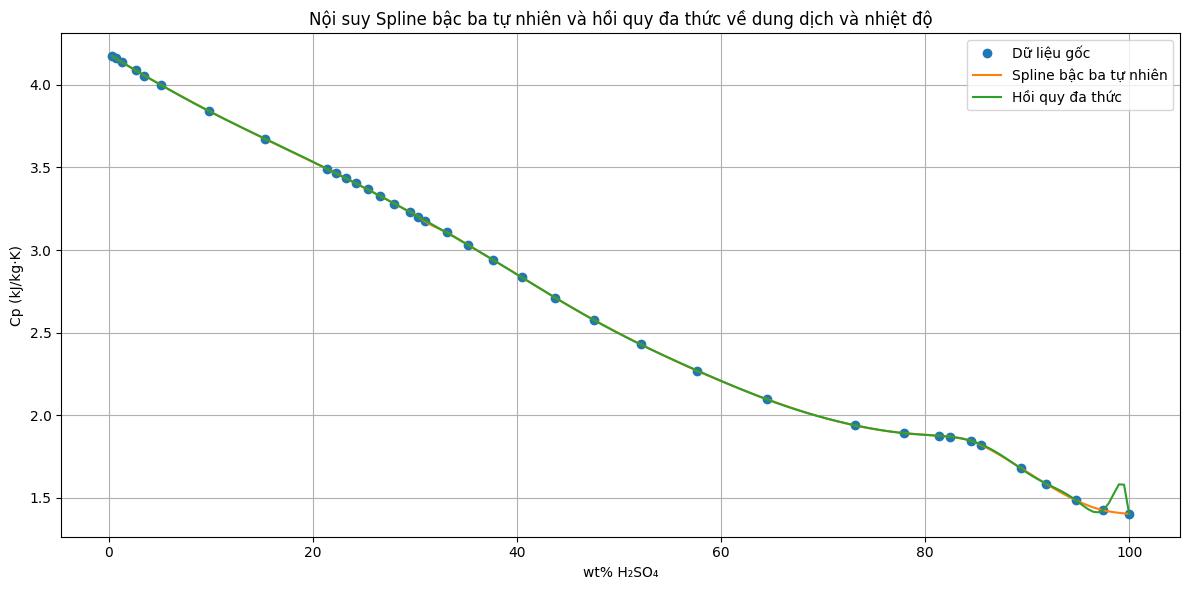

In [5]:
# Bài 1
weight_percent = np.array(
    [
        0.34, 0.68, 1.34, 2.65, 
        3.50, 5.16, 9.82, 15.36, 
        21.40, 22.27, 23.22, 24.25, 
        25.39, 26.63, 28.00, 29.52, 
        30.34, 31.00, 33.11, 35.25, 
        37.69, 40.49, 43.75, 47.57, 
        52.13, 57.65, 64.47, 73.13, 
        77.91, 81.33, 82.49, 84.48, 
        85.48, 89.36, 91.81, 94.82, 
        97.44, 100.00
    ], dtype=float
)

heat_capacity = np.array(
    [
        4.173, 4.160, 4.135, 4.087,
        4.056, 3.998, 3.842, 3.671,
        3.491, 3.465, 3.435, 3.403,
        3.367, 3.326, 3.281, 3.231,
        3.202, 3.173, 3.107, 3.030,
        2.940, 2.834, 2.711, 2.576,
        2.429, 2.269, 2.098, 1.938,
        1.892, 1.876, 1.870, 1.846,
        1.820, 1.681, 1.586, 1.484,
        1.425, 1.403
    ], dtype=float
)
spline_model = NaturalCubicSpline(weight_percent, heat_capacity)
wp_new_spline = np.linspace(min(weight_percent), max(weight_percent), 200)
hc_new_spline = [spline_model.interpolate(xi) for xi in wp_new_spline]

degree = 42
polynominal_model = PolynominalRegression(weight_percent, heat_capacity, degree)
wp_new_regression = np.linspace(min(weight_percent), max(weight_percent), 200)
hc_new_regression = [polynominal_model.predict(xi) for xi in wp_new_regression]

plot_interpolation_results(
    x_original=weight_percent,
    y_original=heat_capacity,
    x_spline=wp_new_spline,
    y_spline=hc_new_spline,
    x_regression=wp_new_regression,
    y_regression=hc_new_regression,
    xlabel='wt% H₂SO₄',
    ylabel='Cp (kJ/kg·K)',
    title='Nội suy Spline bậc ba tự nhiên và hồi quy đa thức về dung dịch và nhiệt độ'
)

# Phân tích xu hướng dữ liệu Covid-19 bằng Spline bậc ba
1. Mục tiêu
    - Hiểu và áp dụng phương pháp spline bậc ba để làm trơn dữ liệu thời gian.
    - Phân tích xu hướng diễn biến của đại dịch Covid-19 dựa trên dữ liệu tần suất theo thời gian
2. Dữ liệu
    - Loại dữ liệu: Số ca nhiễm hàng ngày (không tích lũy) của Covid-19
    - Khu vực: Việt Nam
3. Các công việc
    - Tải dữ liệu (2020-2021 là dữ liệu ta cần lấy của Việt Nam)
    - Tiền xử lý dữ liệu (chuẩn hóa ngày tháng, loại bỏ dữ liệu thiếu hoặc ngoài lai)
    - Áp dụng Spline bậc ba tự nhiên nhằm tìm ra xu hướng chính đã diễn ra
    - Vẽ biểu đồ

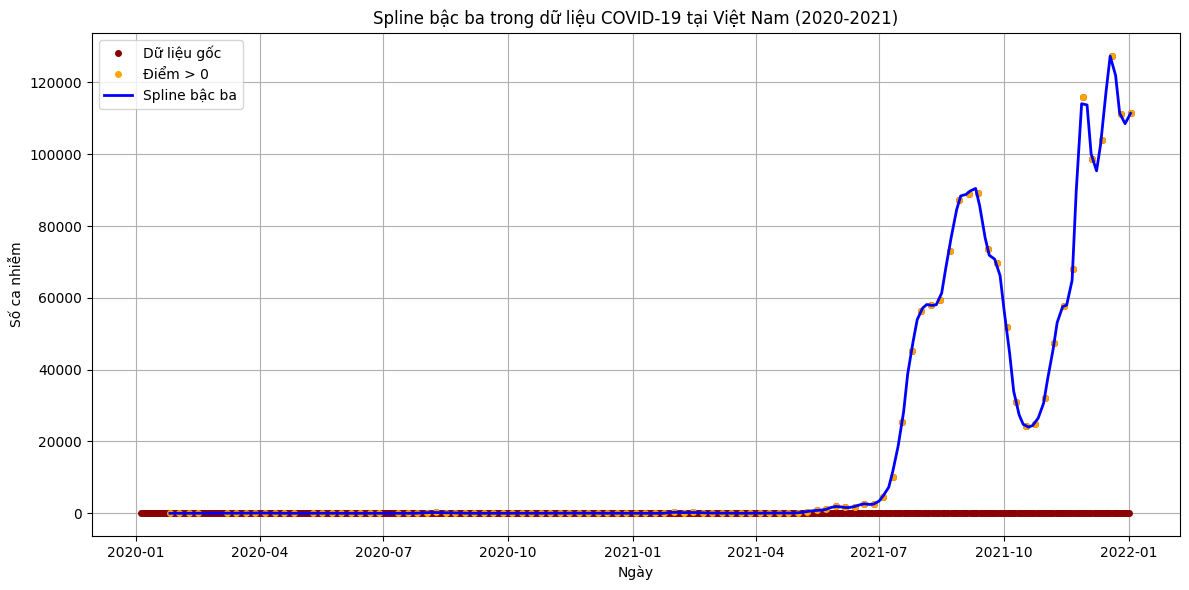

In [ ]:
# Bài 2
# Tải dữ liệu và tiền xử lý dữ liệu
df = pd.read_csv("owid-covid-data.csv")

df_vn_full = df[df["location"] == "Vietnam"]
df_vn_full = df_vn_full[["date", "new_cases"]]
df_vn_full["date"] = pd.to_datetime(df_vn_full["date"])
df_vn_full = df_vn_full[(df_vn_full["date"] >= "2020-01-01") & (df_vn_full["date"] <= "2022-01-02")]
df_vn_full = df_vn_full.dropna(subset=['new_cases'])
df_vn_full["days"] = (df_vn_full["date"] - df_vn_full["date"].min()).dt.days

df_vn_nonzero = df_vn_full[df_vn_full["new_cases"] > 0]
days_nonzero = df_vn_nonzero["days"].tolist()
new_cases_nonzero = df_vn_nonzero["new_cases"].tolist()

spline_model_2 = NaturalCubicSpline(days_nonzero, new_cases_nonzero)

x_smooth = np.linspace(min(days_nonzero), max(days_nonzero), 200)
y_smooth = [spline_model_2.interpolate(xi) for xi in x_smooth]

date_start = df_vn_full["date"].min()
date_smooth = pd.to_datetime([date_start + pd.Timedelta(days=int(x)) for x in x_smooth])

plot_covid_interpolation(
    date_original=df_vn_full["date"],
    new_cases_original=df_vn_full["new_cases"],
    date_nonzero=df_vn_nonzero["date"],
    new_cases_nonzero=df_vn_nonzero["new_cases"],
    date_spline=date_smooth,
    new_cases_spline=y_smooth
)

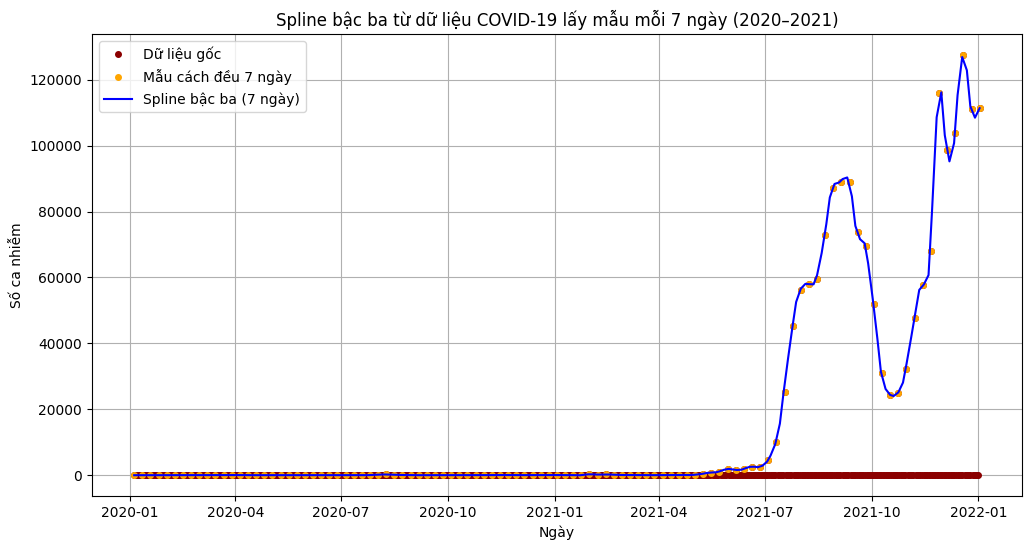

In [28]:
df = pd.read_csv("owid-covid-data.csv")
df_vn = df[df["location"] == "Vietnam"]
df_vn = df_vn[["date", "new_cases"]]

# Xử lý ngày và lọc mốc thời gian
df_vn["date"] = pd.to_datetime(df_vn["date"])
df_vn = df_vn[(df_vn["date"] >= "2020-01-01") & (df_vn["date"] <= "2022-01-02")]
df_vn = df_vn.dropna(subset=["new_cases"])
df_vn["days"] = (df_vn["date"] - df_vn["date"].min()).dt.days

# ==========================
# 🔹 LẤY MẪU CÁCH 7 NGÀY
# ==========================
df_sampled = df_vn.iloc[::7].copy()  # lấy mỗi dòng cách 7 dòng (7 ngày)

# Lấy dữ liệu để nội suy spline
days_sampled = df_sampled["days"].tolist()
new_cases_sampled = df_sampled["new_cases"].tolist()

# Spline nội suy
spline_model = NaturalCubicSpline(days_sampled, new_cases_sampled)
x_smooth = np.linspace(min(days_sampled), max(days_sampled), 200)
y_smooth = [spline_model.interpolate(xi) for xi in x_smooth]

# Chuyển ngày cho trục x
date_start = df_vn["date"].min()
date_smooth = pd.to_datetime([date_start + pd.Timedelta(days=int(x)) for x in x_smooth])

# ==========================
# 🔹 VẼ BIỂU ĐỒ
# ==========================
plt.figure(figsize=(12, 6))
plt.plot(df_vn["date"], df_vn["new_cases"], "o", color="darkred", markersize=4, label="Dữ liệu gốc")
plt.plot(df_sampled["date"], df_sampled["new_cases"], "o", color="orange", markersize=4, label="Mẫu cách đều 7 ngày")
plt.plot(date_smooth, y_smooth, color='blue', label='Spline bậc ba (7 ngày)')

plt.xlabel("Ngày")
plt.ylabel("Số ca nhiễm")
plt.title("Spline bậc ba từ dữ liệu COVID-19 lấy mẫu mỗi 7 ngày (2020–2021)")
plt.legend()
plt.grid(True)
plt.show()